# NLP with disaster tweets

Tiansheng Xu

# 1. Data ingestion

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth',100)

In [2]:
%time df = pd.read_csv('train.csv')

Wall time: 107 ms


In [3]:
df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [4]:
df['text'] = df['text'].astype(str)

# 2. Basic Explore

In [5]:
len(df)

7613

### 2.1 check duplicates

In [6]:
dups = pd.DataFrame((df['text'].value_counts()[df['text'].value_counts()>1]))
print(len(dups)-1)

68


There are some duplicates. We need to remove duplicates with same target

In [7]:
df = df.drop_duplicates(subset = ['text', 'target'])
df = df.drop_duplicates(subset = ['text'],keep = False)
print(len(df))

7485


### 2.2 check nulls

In [8]:
len(df[df['text'].isnull()])

0

### 2.3 check distribution

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
ax = sns.countplot(y = df['target'], palette = "OrRd_r")
ax.set_title('if the data is balanced?')
ax.set_ylabel('Target')
ax.set_xlabel('Number of Observations')
sns.despine(left = True)
plt.show()

<Figure size 640x480 with 1 Axes>

The data is balanced

# 3. preprocessing

### 3.1 clean texts

In [10]:
import re

def clean_string(in_str):
    
    in_str = str(in_str)
    
    # URL
    
    #url_regex = '((https?\://(?!www\.))|((https?\://)?www\.))?' + \
    #            '([a-zA-Z0-9]{2,}\.)+(com|org|net)' + \
    #           '((/[a-zA-Z0-9%#_+?&-]+)+((?<!/)\.[a-zA-Z0-9]{2,})?)?'
    #url_regex =  'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
    
    url_regex = '(https?://\S+)'
    url_regex_comp = re.compile(url_regex)

    in_str = url_regex_comp.sub('<URL>', in_str)
    
    # emails

    email_reg_chars = 'a-zA-Z0-9!#$%&\'*+-=/?^`_~|\{\}'
    email_local_regex = '([' + email_reg_chars + ']+((\.[' + email_reg_chars + '])+)?)'
    email_regex = email_local_regex + ' ?@ ?' + '[a-zA-Z0-9]{2,}((?=\.[a-z]+)\.[a-zA-Z0-9\-]+)*((:[0-9]{2,4})|' + \
                  '( ?(\.|dot) ?[A-Za-z]{2,18}))'
    email_regex_comp = re.compile(email_regex)
    in_str = email_regex_comp.sub('<EMAIL ADDRESS>', in_str)
    
    # Other special characters and numbers
    in_str = re.sub('[^A-Za-z0-9]+', ' ', in_str)

    # lower cases
    in_str = in_str.strip().lower()
        
    # stopwords
        #in_list = [w for w in in_list if w not in stops]
    
    # remove white space
    out_str = re.sub("\s\s+", " ", in_str)
    
    return out_str
    

In [11]:
% time df['clean_text'] = df['text'].apply(clean_string)

Wall time: 575 ms


In [12]:
df[(df['clean_text'].apply(lambda x:x.isspace())) | (df['clean_text'] == '')]

,id,keyword,location,text,target,clean_text


There is no null text after the cleaning

### 3.2 text length

In [13]:
df['num_clean_tokens'] = df['clean_text'].apply(lambda x:len(x.split()))
df['num_clean_tokens'].describe()

count    7485.000000
mean       15.160855
std         5.962249
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        34.000000
Name: num_clean_tokens, dtype: float64

C:\Users\31221\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


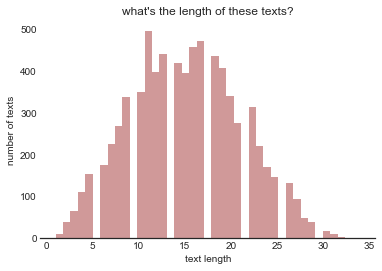

In [16]:
sns.set_style("white")
ax = sns.distplot(df['num_clean_tokens'], kde = False, color = "darkred")
ax.set_title('what\'s the length of these texts?')
ax.set_ylabel('number of texts')
ax.set_xlabel('text length')
sns.despine(left = True)
plt.show()

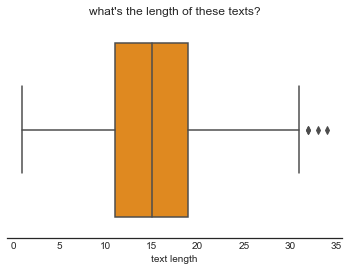

In [17]:
sns.set_style("white")
ax = sns.boxplot(df['num_clean_tokens'], color = "darkorange")
ax.set_title('what\'s the length of these texts?')
ax.set_xlabel('text length')
sns.despine(left = True)
plt.show()

### 3.3 Check n-grams

In [18]:
from nltk import ngrams
from collections import Counter
def top_ngrams(text_list,num):
    ngram_list = []
    for text in text_list:
        text = text.split()
        grams_tok = ngrams(text,num)
        for grams in grams_tok:
            ind_grams = ' '.join(grams)
            ngram_list.append(ind_grams)
    hot_keywords = Counter(ngram_list).most_common()
    gram_word_arr = []
    frequency_arr = []
    for (key,val) in hot_keywords:
        gram_word_arr.append(key)
        frequency_arr.append(val)
    ngram_df = pd.DataFrame({'N-gram':gram_word_arr, 'Frequency':frequency_arr}, columns = ['N-gram','Frequency'])
    
    return ngram_df

In [19]:
%time trigram = top_ngrams(df['clean_text'],3)

Wall time: 276 ms


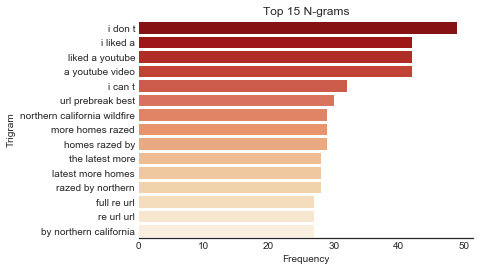

In [20]:
trigram_sub = trigram.head(15)

sns.set_style("white")
ax = sns.barplot(y = trigram_sub['N-gram'], x = trigram_sub['Frequency'], palette = "OrRd_r")
ax.set_title('Top 15 N-grams')
ax.set_ylabel('Trigram')
ax.set_xlabel('Frequency')
sns.despine(left = True)
plt.show()

### 3.4 Check n-grams: Remove stopwords/ lemmatize text 

In [21]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
wordnet_lemmatizer= WordNetLemmatizer()
stop = stopwords.words('english')
df['clean_text_stops'] = df['clean_text'].apply(lambda x:' '.join([word for word in x.split() if word not in (stop)]))
df['clean_text_stops_lemma'] = df['clean_text_stops'].apply(lambda x:' '.join([wordnet_lemmatizer.lemmatize(word) for word in x.split()]))


Wall time: 249 ms


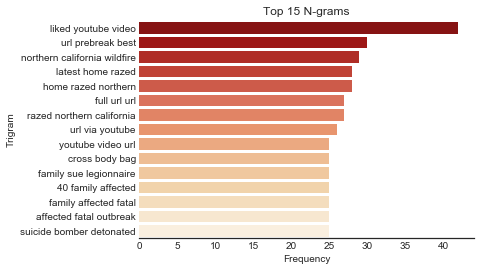

In [22]:
%time trigram = top_ngrams(df['clean_text_stops_lemma'],3)
trigram_sub = trigram.head(15)

sns.set_style("white")
ax = sns.barplot(y = trigram_sub['N-gram'], x = trigram_sub['Frequency'], palette = "OrRd_r")
ax.set_title('Top 15 N-grams')
ax.set_ylabel('Trigram')
ax.set_xlabel('Frequency')
sns.despine(left = True)
plt.show()

# 4. Vectorization

In [23]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.3, random_state = 2020, stratify = df.target.values)

### 4.1 TF-IDF

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,2), max_df = 0.8, min_df = 2)
tfidf_train = tfidf_vectorizer.fit_transform(train['clean_text_stops_lemma'])
tfidf_test = tfidf_vectorizer.transform(test['clean_text_stops_lemma'])
target_train = train['target']
target_test = test['target']

In [25]:
tfidf_train.shape

(5239, 8329)

In [26]:
train['clean_text_stops_lemma'][1]

'forest fire near la ronge sask canada'

### 4.2 Word2Vec - trained from given data

In [27]:
import gensim
from gensim.models import Word2Vec
wv_model = Word2Vec(train['clean_text'].apply(lambda x:x.split()), min_count = 2, size = 200, window = 5, sg = 1, iter = 5)
wv_model.save("word2vec.model")

In [28]:
wv_model.most_similar('fire')

[('truck', 0.9945228099822998),
 ('world', 0.9942434430122375),
 ('story', 0.9937585592269897),
 ('accident', 0.9937041997909546),
 ('year', 0.993523359298706),
 ('alarm', 0.9934950470924377),
 ('history', 0.9934936761856079),
 ('wild', 0.9934236407279968),
 ('report', 0.9933422803878784),
 ('market', 0.9933284521102905)]

In [29]:
wv_model.wv.syn0.shape

(5226, 200)

### 4.3 Word2Vec - pre trained by Google

In [46]:
### https://github.com/FredericGodin/TwitterEmbeddings
### https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

from gensim.models import KeyedVectors
pre_trained_wv_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit = 50000)  

In [47]:
pre_trained_wv_model.most_similar('fire')

[('blaze', 0.7516718506813049),
 ('fires', 0.7222490310668945),
 ('Fire', 0.69910728931427),
 ('flames', 0.6387674808502197),
 ('inferno', 0.6056278347969055),
 ('firefighters', 0.6039329767227173),
 ('blazes', 0.5724145174026489),
 ('wildfire', 0.5685724020004272),
 ('arson', 0.5321768522262573),
 ('firefighting', 0.5299635529518127)]

# 5. Model Training

### 5.1 TFIDF + Logistic Regression

Accuracy Score: 0.8014247551202137
AUC: 0.8600609773398089
[[1167  122]
 [ 324  633]]
             precision    recall  f1-score   support

          0       0.78      0.91      0.84      1289
          1       0.84      0.66      0.74       957

avg / total       0.81      0.80      0.80      2246



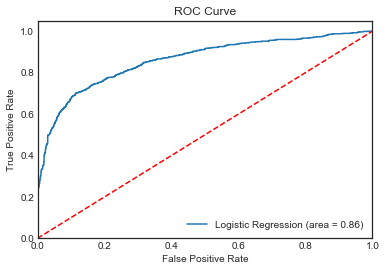

In [30]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

#from sklearn.model_selection import GridSearchCV, PredefinedSplit
classifier = LogisticRegression()
logit_model = classifier.fit(tfidf_train,target_train)
logit_prediction = logit_model.predict(tfidf_test)
logit_prediction_proba = logit_model.predict_proba(tfidf_test)[:,1]
score = accuracy_score(target_test, logit_prediction)
print("Accuracy Score:", score)
logit_roc_auc = roc_auc_score(target_test,logit_prediction_proba)
print("AUC:",logit_roc_auc)
confusion_matrix = confusion_matrix(target_test, logit_prediction)
print(confusion_matrix)
print(classification_report(target_test, logit_prediction))

# Roc curve
fpr,  tpr, thresholds = roc_curve(target_test, logit_prediction_proba)
plt.figure()
plt.plot(fpr,tpr,label ='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc = 'lower right')
plt.show()



### 5.2 TFIDF + LinearSVM

In [31]:
from sklearn.svm import LinearSVC 

#from sklearn.model_selection import GridSearchCV, PredefinedSplit
classifier = LinearSVC()
svm_model = classifier.fit(tfidf_train,target_train)
svm_prediction = svm_model.predict(tfidf_test)
print(svm_prediction)
#svm_prediction_proba = svm_model.predict_proba(tfidf_test)[:,1]
score = accuracy_score(target_test, svm_prediction)
print("Accuracy Score:", score)
#confusion_matrix = confusion_matrix(target_test, svm_prediction)
#print(confusion_matrix)
print(classification_report(target_test, svm_prediction))


[0 1 1 ... 1 0 1]
Accuracy Score: 0.7782724844167409
             precision    recall  f1-score   support

          0       0.79      0.84      0.81      1289
          1       0.76      0.70      0.73       957

avg / total       0.78      0.78      0.78      2246



### 5.3 word2vec + LSTM

In [33]:
seq_length = 35
wv_weights = wv_model.wv.vectors
vocab_size, embedding_size = wv_model.wv.vectors.shape

In [34]:
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences

def word2token(word):
    try:
        return wv_model.wv.vocab[word].index
    except KeyError:
        return 0

w2v_train, w2v_val = train_test_split(train, test_size = 0.25, random_state = 2020, stratify = train.target.values)

train_docLabels = w2v_train['id']
train_data = pad_sequences(np.array(w2v_train['clean_text'].apply(lambda x:[word2token(w) for w in x.split()[:seq_length] if w!=''])), 
                          maxlen = seq_length, padding = 'pre', value = 0)
train_flag = w2v_train['target']

val_docLabels = w2v_val['id']
val_data = pad_sequences(np.array(w2v_val['clean_text'].apply(lambda x:[word2token(w) for w in x.split()[:seq_length] if w!=''])),
                        maxlen = seq_length, padding = 'pre', value = 0)
val_flag = w2v_val['target']

test_docLabels = test['id']
test_data = pad_sequences(np.array(test['clean_text'].apply(lambda x:[word2token(w) for w in x.split()[:seq_length] if w!=''])),
                         maxlen = seq_length, padding = 'pre', value = 0)
test_flag = test['target']

Using TensorFlow backend.


In [35]:
train_data.shape

(3929, 35)

In [36]:
lstm_model = Sequential()
lstm_model.add(Embedding(
    input_dim = vocab_size,
    output_dim = embedding_size,
    weights = [wv_weights],
    input_length = seq_length,
    mask_zero = True,
    trainable = False
))
lstm_model.add(Bidirectional(LSTM(200)))
lstm_model.add(Dense(2, activation = 'sigmoid'))
lstm_model.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy',metrics = ['accuracy'])
history = lstm_model.fit(train_data, train_flag, epochs=5, batch_size = 64, validation_data = (val_data, val_flag), verbose = 1)
lstm_model.save('w2v_model_v1.h5')

Train on 3929 samples, validate on 1310 samples
Epoch 1/5
3929/3929 [==============================] - 28s 7ms/step - loss: 0.6051 - acc: 0.6724 - val_loss: 0.5944 - val_acc: 0.6870
Epoch 2/5
3929/3929 [==============================] - 22s 6ms/step - loss: 0.5813 - acc: 0.6984 - val_loss: 0.5776 - val_acc: 0.7008
Epoch 3/5
3929/3929 [==============================] - 23s 6ms/step - loss: 0.5860 - acc: 0.6948 - val_loss: 0.6093 - val_acc: 0.6588
Epoch 4/5
3929/3929 [==============================] - 24s 6ms/step - loss: 0.5833 - acc: 0.6984 - val_loss: 0.5733 - val_acc: 0.7008
Epoch 5/5
3929/3929 [==============================] - 25s 6ms/step - loss: 0.5745 - acc: 0.6992 - val_loss: 0.5695 - val_acc: 0.7115


Need more data to train 

Accuracy Score: 0.7003561887800535
AUC: 0.7610441376391992
             precision    recall  f1-score   support

          0       0.71      0.81      0.76      1289
          1       0.69      0.55      0.61       957

avg / total       0.70      0.70      0.69      2246



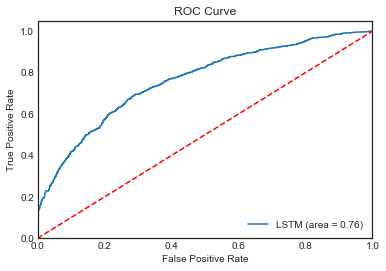

In [37]:
lstm_prediction_proba = lstm_model.predict_proba(test_data)[:,1]
lstm_prediction = lstm_model.predict_proba(test_data).argmax(axis=1)
score = accuracy_score(target_test, lstm_prediction)
print("Accuracy Score:", score)
lstm_roc_auc = roc_auc_score(target_test,lstm_prediction_proba)
print("AUC:",lstm_roc_auc)
#confusion_matrix = confusion_matrix(target_test, lstm_prediction)
#print(confusion_matrix)
print(classification_report(target_test, lstm_prediction))

# Roc curve
fpr,  tpr, thresholds = roc_curve(target_test, lstm_prediction_proba)
plt.figure()
plt.plot(fpr,tpr,label ='LSTM (area = %0.2f)' % lstm_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc = 'lower right')
plt.show()


### 5.4 pre trained Word2Vec + LSTM

In [48]:
seq_length = 35
wv_weights = pre_trained_wv_model.wv.vectors
vocab_size, embedding_size = pre_trained_wv_model.wv.vectors.shape

In [49]:
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences

def word2token(word):
    try:
        return pre_trained_wv_model.wv.vocab[word].index
    except KeyError:
        return 0

w2v_train, w2v_val = train_test_split(train, test_size = 0.25, random_state = 2020, stratify = train.target.values)

train_docLabels = w2v_train['id']
train_data = pad_sequences(np.array(w2v_train['clean_text'].apply(lambda x:[word2token(w) for w in x.split()[:seq_length] if w!=''])), 
                          maxlen = seq_length, padding = 'pre', value = 0)
train_flag = w2v_train['target']

val_docLabels = w2v_val['id']
val_data = pad_sequences(np.array(w2v_val['clean_text'].apply(lambda x:[word2token(w) for w in x.split()[:seq_length] if w!=''])),
                        maxlen = seq_length, padding = 'pre', value = 0)
val_flag = w2v_val['target']

test_docLabels = test['id']
test_data = pad_sequences(np.array(test['clean_text'].apply(lambda x:[word2token(w) for w in x.split()[:seq_length] if w!=''])),
                         maxlen = seq_length, padding = 'pre', value = 0)
test_flag = test['target']

In [51]:
lstm_model = Sequential()
lstm_model.add(Embedding(
    input_dim = vocab_size,
    output_dim = embedding_size,
    weights = [wv_weights],
    input_length = seq_length,
    mask_zero = True,
    trainable = False
))
lstm_model.add(Bidirectional(LSTM(200)))
lstm_model.add(Dense(2, activation = 'sigmoid'))
lstm_model.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy',metrics = ['accuracy'])
history = lstm_model.fit(train_data, train_flag, epochs=3, batch_size = 64, validation_data = (val_data, val_flag), verbose = 1)

Train on 3929 samples, validate on 1310 samples
Epoch 1/3
3929/3929 [==============================] - 32s 8ms/step - loss: 0.4990 - acc: 0.7684 - val_loss: 0.4507 - val_acc: 0.8038
Epoch 2/3
3929/3929 [==============================] - 29s 7ms/step - loss: 0.4272 - acc: 0.8173 - val_loss: 0.4434 - val_acc: 0.8061
Epoch 3/3
3929/3929 [==============================] - 29s 8ms/step - loss: 0.3937 - acc: 0.8297 - val_loss: 0.4445 - val_acc: 0.8145


Accuracy Score: 0.7978628673196795
AUC: 0.861810772447192
             precision    recall  f1-score   support

          0       0.80      0.87      0.83      1289
          1       0.80      0.70      0.75       957

avg / total       0.80      0.80      0.80      2246



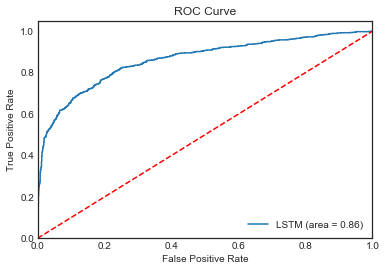

In [52]:
lstm_prediction_proba = lstm_model.predict_proba(test_data)[:,1]
lstm_prediction = lstm_model.predict_proba(test_data).argmax(axis=1)
score = accuracy_score(target_test, lstm_prediction)
print("Accuracy Score:", score)
lstm_roc_auc = roc_auc_score(target_test,lstm_prediction_proba)
print("AUC:",lstm_roc_auc)
#confusion_matrix = confusion_matrix(target_test, lstm_prediction)
#print(confusion_matrix)
print(classification_report(target_test, lstm_prediction))

# Roc curve
fpr,  tpr, thresholds = roc_curve(target_test, lstm_prediction_proba)
plt.figure()
plt.plot(fpr,tpr,label ='LSTM (area = %0.2f)' % lstm_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc = 'lower right')
plt.show()

This result looks better. need more time spent on cleaning steps

### 5.5 pre trained BERT